In [363]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

#### This is just the simple example of bootstrap with little data preparation and no EDA

In [305]:
df = pd.read_csv('/Users/vladimiregorov/Downloads/AB_Test_Results.csv')

In [357]:
df.shape

(9999, 3)

In [306]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [307]:
df = df.rename(columns = {'USER_ID' : 'user_id', 'VARIANT_NAME' : 'sample', 'REVENUE' : 'revenue'})

#### Let's see if there are any outliers in both control and test samples

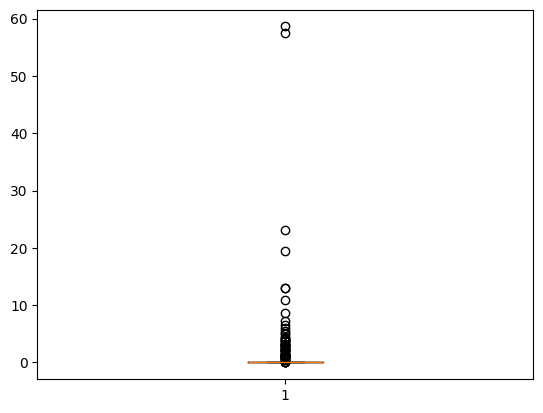

In [308]:
plt.boxplot(df.loc[df['sample'] == 'variant', 'revenue'])
plt.show()

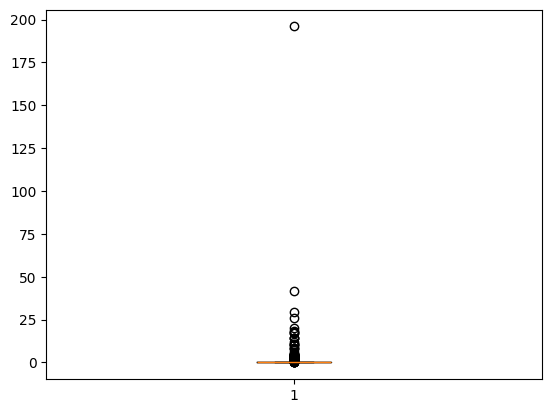

In [309]:
plt.boxplot(df.loc[df['sample'] == 'control', 'revenue'])
plt.show()

#### As we can see thera are some outliers , let's delete them

In [310]:
df.sort_values('revenue')

,user_id,sample,revenue
0,737,variant,0.00
6635,3405,control,0.00
6636,9921,variant,0.00
6637,442,variant,0.00
6638,9539,control,0.00
...,...,...,...
8168,2166,control,29.32
9421,6792,control,41.53
7642,7206,variant,57.46
6447,2881,variant,58.63


In [311]:
df = df[df['revenue'] < 100]

#### Let's look at means

In [312]:
print(df.loc[(df['sample'] == 'variant'), 'revenue'].mean())
print(df.loc[(df['sample'] == 'control'), 'revenue'].mean())

0.07006977671451356
0.08970299016656633


#### Let's do the test on those, from which users we have the revenue

In [313]:
# these are our data we will work with

test = np.array(df.loc[(df['sample'] == 'variant') & (df['revenue'] > 0), 'revenue'])
control = np.array(df.loc[(df['sample'] == 'control') & (df['revenue'] > 0), 'revenue'])

In [314]:
print(test.mean())
print(control.mean())


4.881527777777778
5.6581012658227845


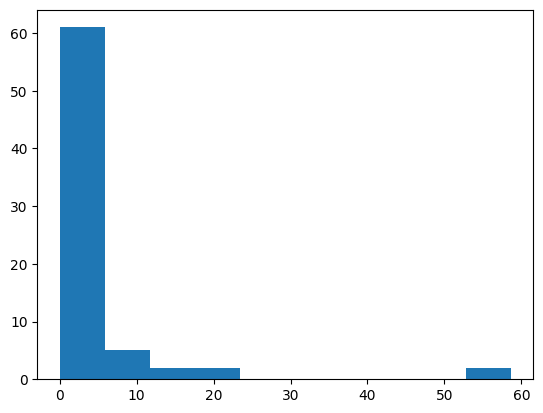

In [315]:
plt.hist(test)
plt.show()

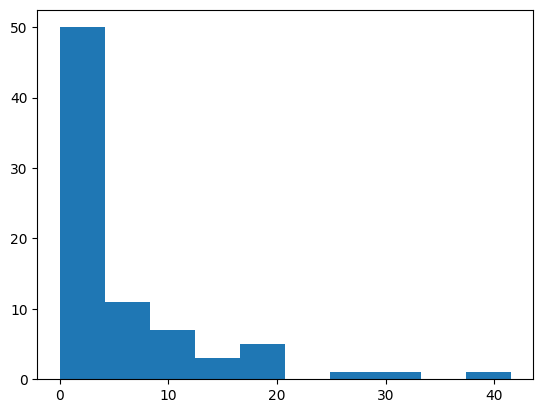

In [316]:
plt.hist(control)
plt.show()

#### let's use the bootstrap here. Firstly we will build efronof c.i and then holl c.i (t-value)

In [317]:
print(test.size)
print(control.size)

72
79


#### we will use c.i firstly, where theta is the difference 

$$
(\theta_{\text{lower}}, \theta_{\text{upper}}) = (\theta_{\alpha}, \theta_{1 - \alpha})
$$

In [323]:
theta_hat = control.mean() - test.mean()
theta_hat

0.7765734880450061

In [335]:
# bootstrap function

def bootstrap(x, q):
    samples = np.random.choice(x, size = (72, q), replace = True)
    return samples

In [336]:
# do bootstrap

test_samples = bootstrap(test, 3000)
control_samples = bootstrap(control, 3000)

In [338]:
test_samples.shape

(72, 3000)

(array([ 27., 202., 440., 630., 592., 497., 296., 168.,  88.,  34.,  13.,
          9.,   1.,   3.]),
 array([ 2.15958333,  2.76078373,  3.36198413,  3.96318452,  4.56438492,
         5.16558532,  5.76678571,  6.36798611,  6.96918651,  7.5703869 ,
         8.1715873 ,  8.7727877 ,  9.3739881 ,  9.97518849, 10.57638889]),
 <BarContainer object of 14 artists>)

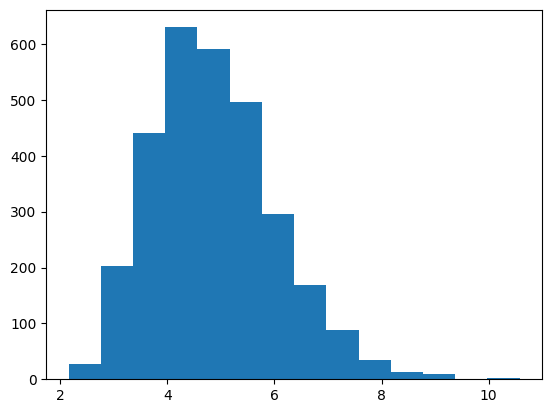

In [340]:
# extract means

test_samples_mean = test_samples.mean(axis = 0)
plt.hist(test_samples_mean, bins = 14)

(array([  4.,  38., 138., 311., 464., 594., 553., 377., 253., 146.,  77.,
         29.,  12.,   4.]),
 array([3.22916667, 3.63166667, 4.03416667, 4.43666667, 4.83916667,
        5.24166667, 5.64416667, 6.04666667, 6.44916667, 6.85166667,
        7.25416667, 7.65666667, 8.05916667, 8.46166667, 8.86416667]),
 <BarContainer object of 14 artists>)

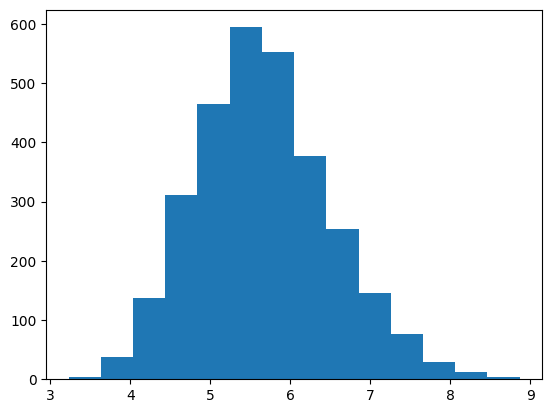

In [341]:
# extract means

control_samples_mean = control_samples.mean(axis = 0)
plt.hist(control_samples_mean, bins = 14)

In [348]:
theta = control_samples_mean - test_samples_mean
theta_hat = control.mean() - test.mean()
result = theta - theta_hat

In [355]:
left = np.quantile(result, 0.025)
right = np.quantile(result, 1 - 0.025)
print(left, right)

-2.9146880713783387 2.711527206399441


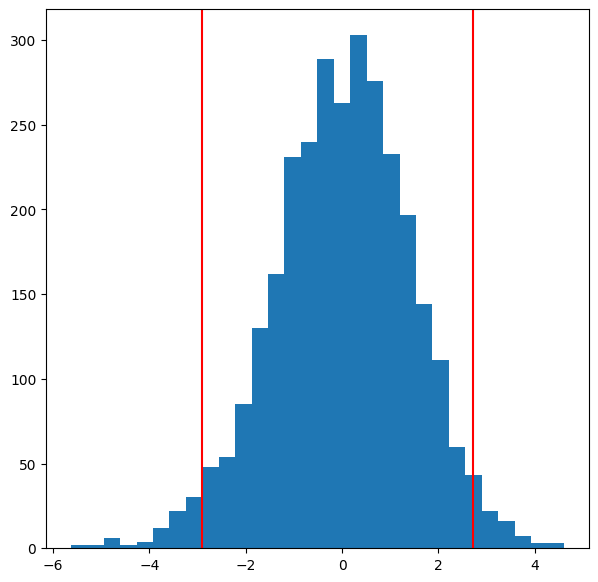

In [379]:
figure =plt.figure(figsize = (7,7))
ax = figure.add_subplot()
ax.hist(result, bins=30)
ax.axvline(left, color='red')
ax.axvline(right, color='red')
plt.show()

#### as zero in the c.i we don't reject the H0 about the equality of means

#### let's count the holla c.i using the formula : 

$$
t_i = \frac{\hat{\theta}^*_i - \hat{\theta}}{\hat{SE}^*_i }
$$

#### with such c.i : 

$$
[\hat{\theta} - t_{1 - \alpha} * se(\hat{\theta}) ; \hat{\theta} - t_{\alpha} * se(\hat{\theta})]
$$

In [381]:
theta = control_samples_mean - test_samples_mean

In [382]:
# this will be used in the c.i

theta_se = theta.std() / np.sqrt(72)

In [402]:
# let's calculate se fot t-value using bootstrap again :)

se_test = []

for i in tqdm(test_samples):
    test_samples_2 = bootstrap(i, 1000)
    means = test_samples_2.mean(axis = 1)
    se = means.std() / np.sqrt(72)
    se_test.append(se)

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 789.52it/s]


In [403]:
se_control = []

for i in tqdm(control_samples):
    control_samples_2 = bootstrap(i, 1000)
    means = control_samples_2.mean(axis = 1)
    se = means.std() / np.sqrt(72)
    se_control.append(se)

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 784.51it/s]


In [404]:
len(theta)

3000

In [392]:
se_diff = np.array(se_control) - np.array(se_test)

In [405]:
# finaly this is t-statistics

t = (np.random.choice(theta, size = 72) - theta_hat) / se_diff

In [406]:
right = theta_hat - np.quantile(t, 0.025)*theta_std
left = theta_hat - np.quantile(t, 1-0.025)*theta_std

(array([ 1.,  2.,  2.,  7., 10., 13., 13., 15.,  3.,  2.,  2.,  2.]),
 array([-133.89930988, -113.17636886,  -92.45342784,  -71.73048682,
         -51.00754579,  -30.28460477,   -9.56166375,   11.16127727,
          31.88421829,   52.60715931,   73.33010033,   94.05304136,
         114.77598238]),
 <BarContainer object of 12 artists>)

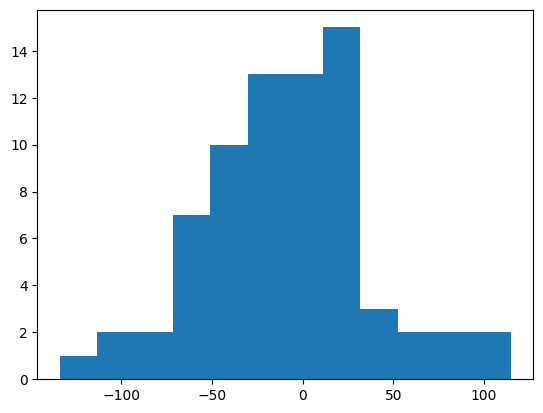

In [409]:
plt.hist(t, bins=12)